In [2]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from cluster_g_logit_init_acceptpsi import *
from datetime import datetime
import pandas as pd
import logging


# Set number of threads for different backends


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def ensure_output_dir(base_dir):
    """Ensure directory exists; create if not."""
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    return base_dir

def load_model_essentials(base_path='/users/sarahurbut/Dropbox (Personal)/filesforupload/'):
    """Load all essential components"""
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    essentials = torch.load(base_path + 'model_essentials.pt')
    return Y, E, G, essentials

def initialize_logging(log_dir):
    """Set up logging."""
    log_file = os.path.join(log_dir, 'run.log')
    logging.basicConfig(
        filename=log_file,
        filemode='w',
        level=logging.INFO,
        format='%(asctime)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    logging.info("Logging initialized.")

def subset_data(Y, E, G, start_index, end_index):
  indices = range(start_index, end_index)
  Y_sub = Y[indices]
  E_sub = E[indices]
  G_sub = G[indices]
  logging.info(f"Data subsetted from index {start_index} to {end_index}.")
  return Y_sub, E_sub, G_sub, indices
    
def plot_calibration(model, plot_dir):
    """Plot calibration curves and calculate R2"""
    predicted = model.forward()
    pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
    pi_pred = pi_pred.cpu().detach().numpy()
    Y = model.Y.cpu().detach().numpy()

    observed_risk = Y.mean(axis=0).flatten()
    predicted_risk = pi_pred.mean(axis=0).flatten()
    scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
    calibrated_risk = predicted_risk * scale_factor

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.scatter(observed_risk, predicted_risk, alpha=0.5)
    plt.plot([0, 0.02], [0, 0.02], 'r--')
    plt.title('Original Predictions')
    plt.xlabel('Observed Risk')
    plt.ylabel('Predicted Risk')

    plt.subplot(122)
    plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
    plt.plot([0, 0.02], [0, 0.02], 'r--')
    plt.title('Calibrated Predictions')
    plt.xlabel('Observed Risk')
    plt.ylabel('Calibrated Risk')

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'calibration.png'))
    plt.close()

    # Save statistics to file
    with open(os.path.join(plot_dir, 'calibration_stats.txt'), 'w') as f:
        f.write(f"Mean observed risk: {np.mean(observed_risk):.6f}\n")
        f.write(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}\n")
        f.write(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}\n")
        f.write(f"Calibration scale factor: {scale_factor:.3f}\n")
        ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
        ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        f.write(f"R^2: {r2:.3f}\n")

def plot_signature_top_diseases_centered(model, disease_names, plot_dir, n_top=10):
    """Show top diseases for each signature, centered relative to prevalence"""
    phi = model.phi.detach().numpy()
    prevalence_logit = model.logit_prev_t.detach().numpy()
    
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    phi_avg = phi_centered.mean(axis=2)
    
    # Save to text file
    with open(os.path.join(plot_dir, 'top_diseases.txt'), 'w') as f:
        for k in range(phi_avg.shape[0]):
            scores = phi_avg[k, :]
            top_indices = np.argsort(scores)[-n_top:][::-1]
            
            f.write(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):\n")
            for idx in top_indices:
                avg_effect = scores[idx]
                temporal_std = np.std(phi_centered[k, idx, :])
                # Safely access disease name, assuming it's a DataFrame with a single column
                try:
                    if isinstance(disease_names, pd.DataFrame):
                        disease_name = disease_names.iloc[idx, 0]
                    else:
                        disease_name = disease_names[idx]
                except IndexError:
                    disease_name = f"Disease_{idx}"
                odds_ratio = np.exp(avg_effect)
                f.write(f"{disease_name}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}\n")

def compare_disease_rankings(model, disease_names, plot_dir, n_top=10):
    """Compare initial vs final disease rankings for each signature"""
    
    psi = model.psi.detach().numpy()
    phi = model.phi.detach().numpy()
    prevalence_logit = model.logit_prev_t.detach().numpy()
    
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    phi_avg = phi_centered.mean(axis=2)
    
    # Save to text file
    with open(os.path.join(plot_dir, 'disease_rankings.txt'), 'w') as f:
        for k in range(phi_avg.shape[0]):
            f.write(f"\nSignature {k}:\n")
            
            initial_scores = psi[k, :]
            initial_top = np.argsort(initial_scores)[-n_top:][::-1]
            
            final_scores = phi_avg[k, :]
            final_top = np.argsort(final_scores)[-n_top:][::-1]
            
            f.write("\nInitial top diseases:\n")
            for i, idx in enumerate(initial_top):
                disease_name = disease_names.iloc[idx] if hasattr(disease_names, 'iloc') else disease_names[idx]
                f.write(f"{i+1}. {disease_name}: {initial_scores[idx]:.3f}\n")
                
            f.write("\nFinal top diseases:\n")
            for i, idx in enumerate(final_top):
                disease_name = disease_names.iloc[idx] if hasattr(disease_names, 'iloc') else disease_names[idx]
                f.write(f"{i+1}. {disease_name}: {final_scores[idx]:.3f}\n")
            
            initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
            final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
            
            changed_diseases = set(initial_top) | set(final_top)
            for disease in changed_diseases:
                initial_rank = initial_ranks.get(disease, n_top+1)
                final_rank = final_ranks.get(disease, n_top+1)
                if abs(final_rank - initial_rank) > 2:
                    disease_name = disease_names.iloc[disease] if hasattr(disease_names, 'iloc') else disease_names[disease]
                    f.write(f"\n{disease_name} changed from rank {initial_rank+1} to {final_rank+1}\n")

def plot_signature_temporal_patterns(model, disease_names, plot_dir, n_top=10, selected_signatures=None):
    """Show temporal patterns of top diseases for each signature"""
    phi = model.phi.detach().numpy()
    prevalence_logit = model.logit_prev_t.detach().numpy()
    
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    phi_avg = phi_centered.mean(axis=2)
    
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            disease_name = disease_names[idx]
            ax.plot(temporal_pattern, label=disease_name)
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'temporal_patterns.png'))
    plt.close()

def train_and_evaluate(start_index, end_index, work_dir):
    # Load and subset data
    Y, E, G, essentials = load_model_essentials()
    Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G,start_index, end_index)
    
    # Convert disease_names to list if it's not already
    disease_names = essentials['disease_names']
    if isinstance(disease_names, pd.DataFrame):
        disease_names = disease_names.iloc[:, 0].tolist()
    elif isinstance(disease_names, pd.Series):
        disease_names = disease_names.tolist()
    logging.info("Starting training process.")
    # Initialize model
    
    
    # Create timestamp and paths
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = ensure_output_dir(os.path.join(work_dir, f'output_{start_index}_{end_index}_{timestamp}'))
    plot_dir = ensure_output_dir(os.path.join(output_dir, 'plots'))
    #save_path = f'/home/ubuntu/aladynoulli/output/model/1/_{timestamp}_{config_str}.pt'
    initialize_logging(output_dir)

    initial_psi = torch.load('initial_psi_400k.pt')
    initial_clusters = torch.load('initial_clusters_400k.pt')

    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=Y_100k.shape[0],
        D=Y_100k.shape[1],
        T=Y_100k.shape[2],
        K=essentials['K'],
        P=essentials['P'],
        G=G_100k,
        Y=Y_100k,
        prevalence_t=essentials['prevalence_t']
    )

    # Initialize and train
    
    model.initialize_params(true_psi=initial_psi)
    model.clusters = initial_clusters
    clusters_match = np.array_equal(initial_clusters, model.clusters)
    print(f"\nClusters match exactly: {clusters_match}")  

    if not clusters_match:
        differences = np.where(initial_clusters != model.clusters)[0]
        print(f"\nFound {len(differences)} differences in cluster assignments")
        print("First few differences:")
        for idx in differences[:5]:
            print(f"Disease {idx}: Original cluster {original_clusters[idx]} vs New cluster {batch_model.clusters[idx]}")  

    print("Psi values match:", torch.allclose(model.psi, initial_psi))
    logging.info("Model initialized with parameters.")
    # Save initial plots

    # Check G matrix scaling
    G_mean = model.G.mean(dim=0)
    G_std = model.G.std(dim=0)
    
    print("\nG matrix scaling check:")
    print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
    print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")
    logging.info(f"G matrix scaling - Max abs mean: {G_mean.abs().max().item():.6f}, Max std dev from 1: {(G_std - 1).abs().max().item():.6f}")


    plt.figure()
    model.plot_initial_params()
    plt.savefig(os.path.join(plot_dir, 'initial_params.png'))
    plt.close()

    
    plt.figure()
    model.visualize_initialization()
    plt.savefig(os.path.join(plot_dir, 'initialization.png'))
    plt.close()
    
    # Train model
    history = model.fit(E_100k, num_epochs=1, learning_rate=1e-4, lambda_reg=1e-2)
    logging.info("Model training completed.")
    model_save_path = os.path.join(output_dir, 'model.pt')
    # Save model and results
    torch.save({
        'model_state_dict': model.state_dict(),
        'clusters': model.clusters,
        'psi': model.psi,
        'Y': Y_100k,
        'prevalence_t': essentials['prevalence_t'],
        'logit_prevalence_t': model.logit_prev_t,
        'G': G_100k,
        'E': E,
        'indices': indices,
        'disease_names': disease_names,
        'hyperparameters': {
            'N': Y_100k.shape[0],
            'D': Y_100k.shape[1],
            'T': Y_100k.shape[2],
            'P': G_100k.shape[1],
            'K': model.phi.shape[0]
        }
    }, model_save_path)
    logging.info(f"Model saved to {model_save_path}.")
    return model, history, disease_names, plot_dir

def plot_results(model, history, disease_names, plot_dir):
    logging.info("Generating plots.")
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(history['loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)

    ax2.plot(history['max_grad_lambda'], label='Lambda')
    ax2.plot(history['max_grad_phi'], label='Phi')
    ax2.plot(history['max_grad_gamma'], label='Gamma')
    ax2.plot(history['max_grad_psi'], label='Psi')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Max Gradient Magnitude')
    ax2.set_title('Parameter Gradients')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'training_history.png'))
    plt.close()

    # Plot calibration
    plot_calibration(model, plot_dir)

    # Plot disease rankings and patterns
    plot_signature_top_diseases_centered(model, disease_names, plot_dir)
    compare_disease_rankings(model, disease_names, plot_dir)
 
    
    plt.figure()
    model.visualize_initialization()
    plt.savefig(os.path.join(plot_dir, 'final_initialization.png'))
    plt.close()
    
    plot_signature_temporal_patterns(model, disease_names, plot_dir, selected_signatures=[0,1,14,15,16,13,17])

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_17898/3717200596.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initialization complete!

Using true psi from simulation
Initialization complete!

Clusters match exactly: True
Psi values match: True

G matrix scaling check:
Mean should be ~0: 0.000000
Std should be ~1: 0.000050


<Figure size 640x480 with 0 Axes>

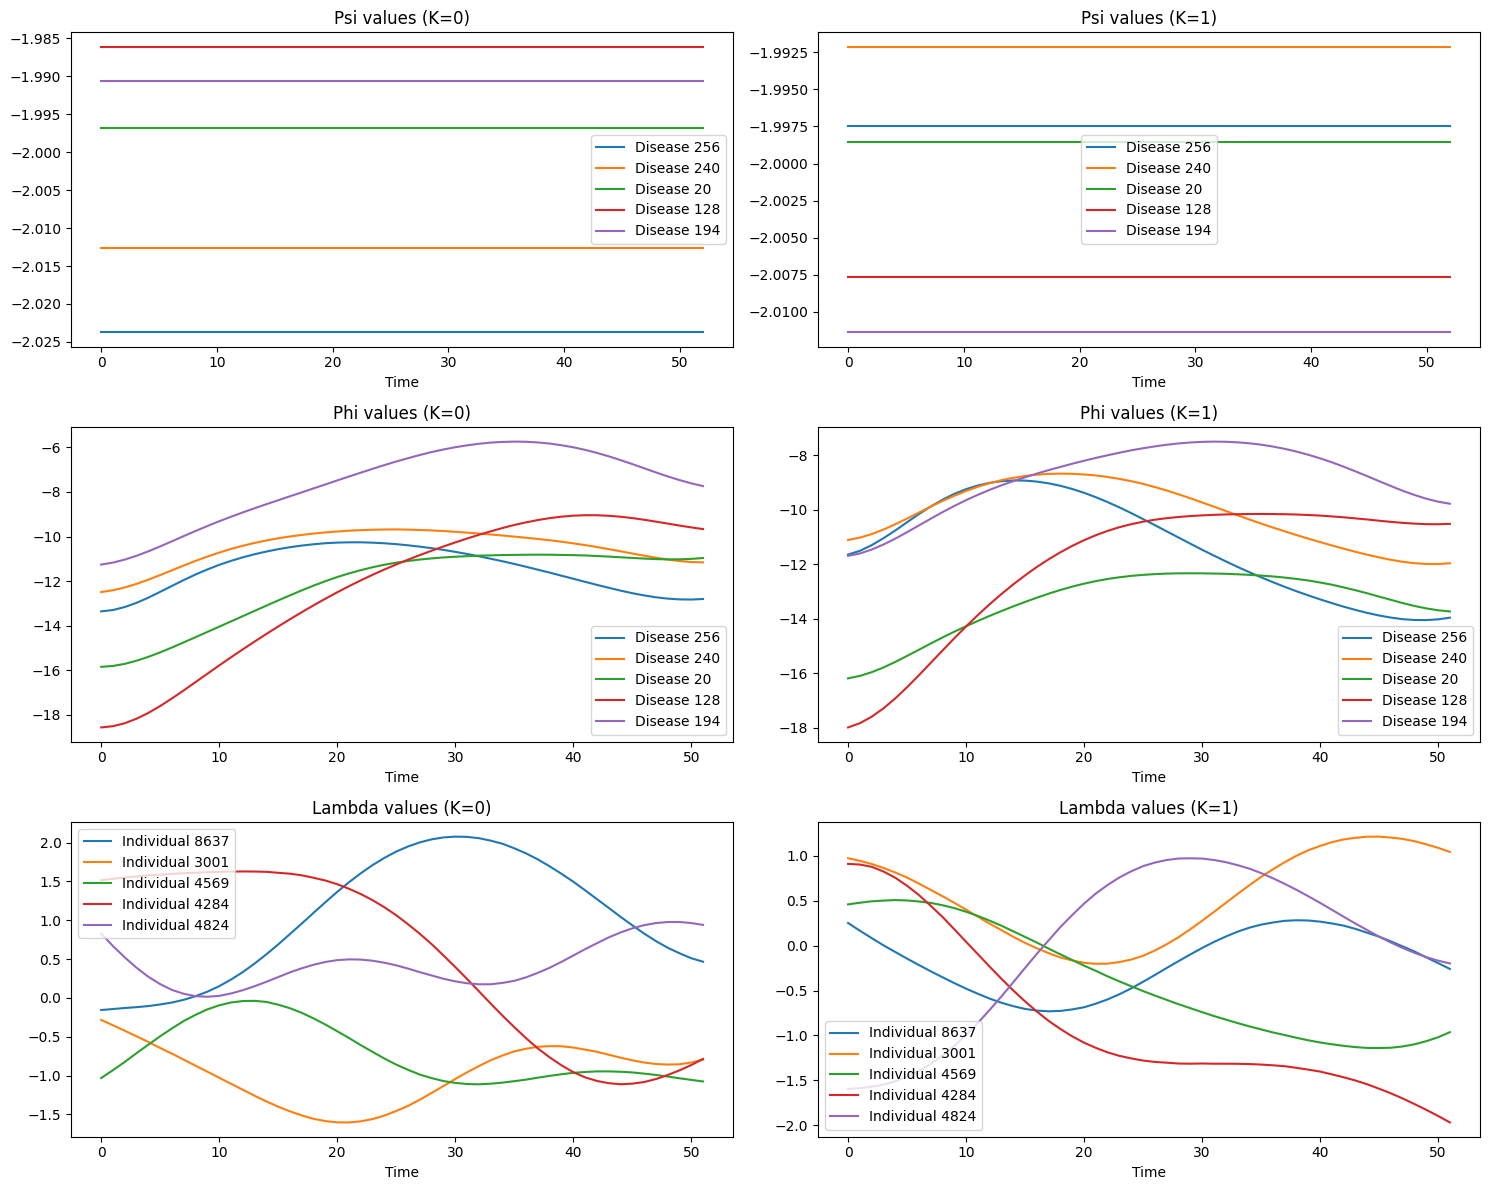


Cluster membership for sampled diseases:
Disease 256: Cluster 3
Disease 240: Cluster 12
Disease 20: Cluster 8
Disease 128: Cluster 3
Disease 194: Cluster 3


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:710: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

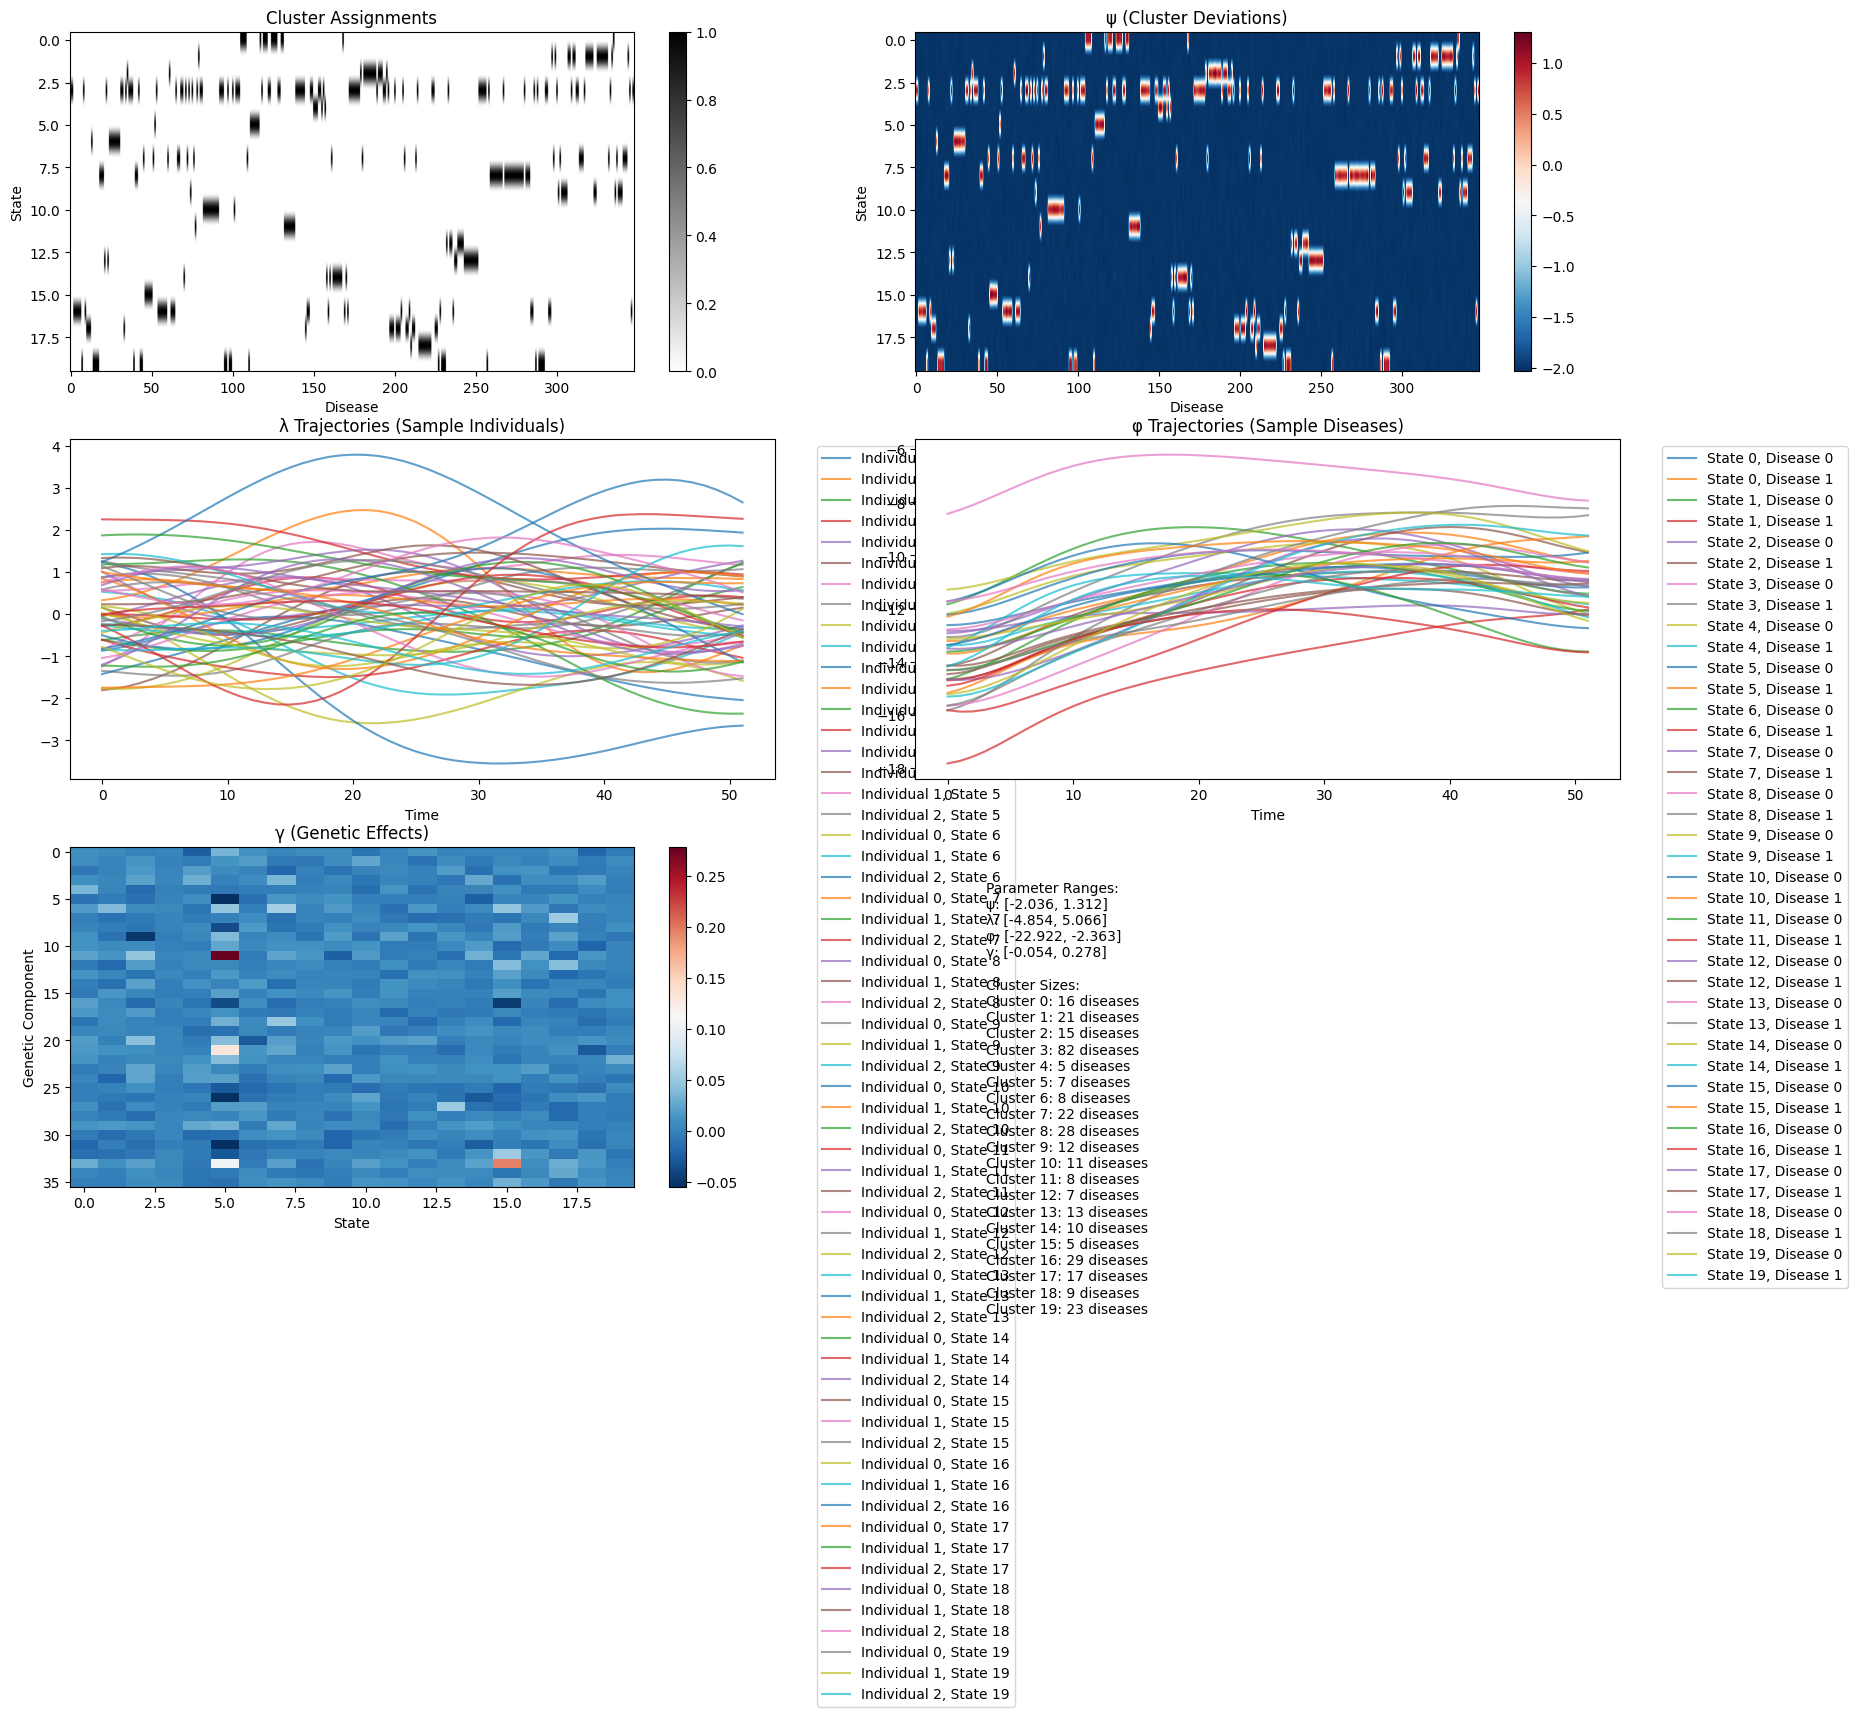

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 1106.6057
Psi gradient stats:
Mean: -6.3317e-05
Std:  4.7247e-03
Max:  1.8089e-02
Min:  -1.7701e-02
Epoch 0, Loss: 1106.6057, Gradients - Lambda: 5.216e-01, Phi: 1.288e+01, Gamma: 5.423e-02, Psi: 1.809e-02


In [8]:
model, history, disease_names, plot_dir = train_and_evaluate(
        start_index=0,
        end_index=10000,
        work_dir='/Users/sarahurbut/Dropbox (Personal)/'
    )

<Figure size 640x480 with 0 Axes>

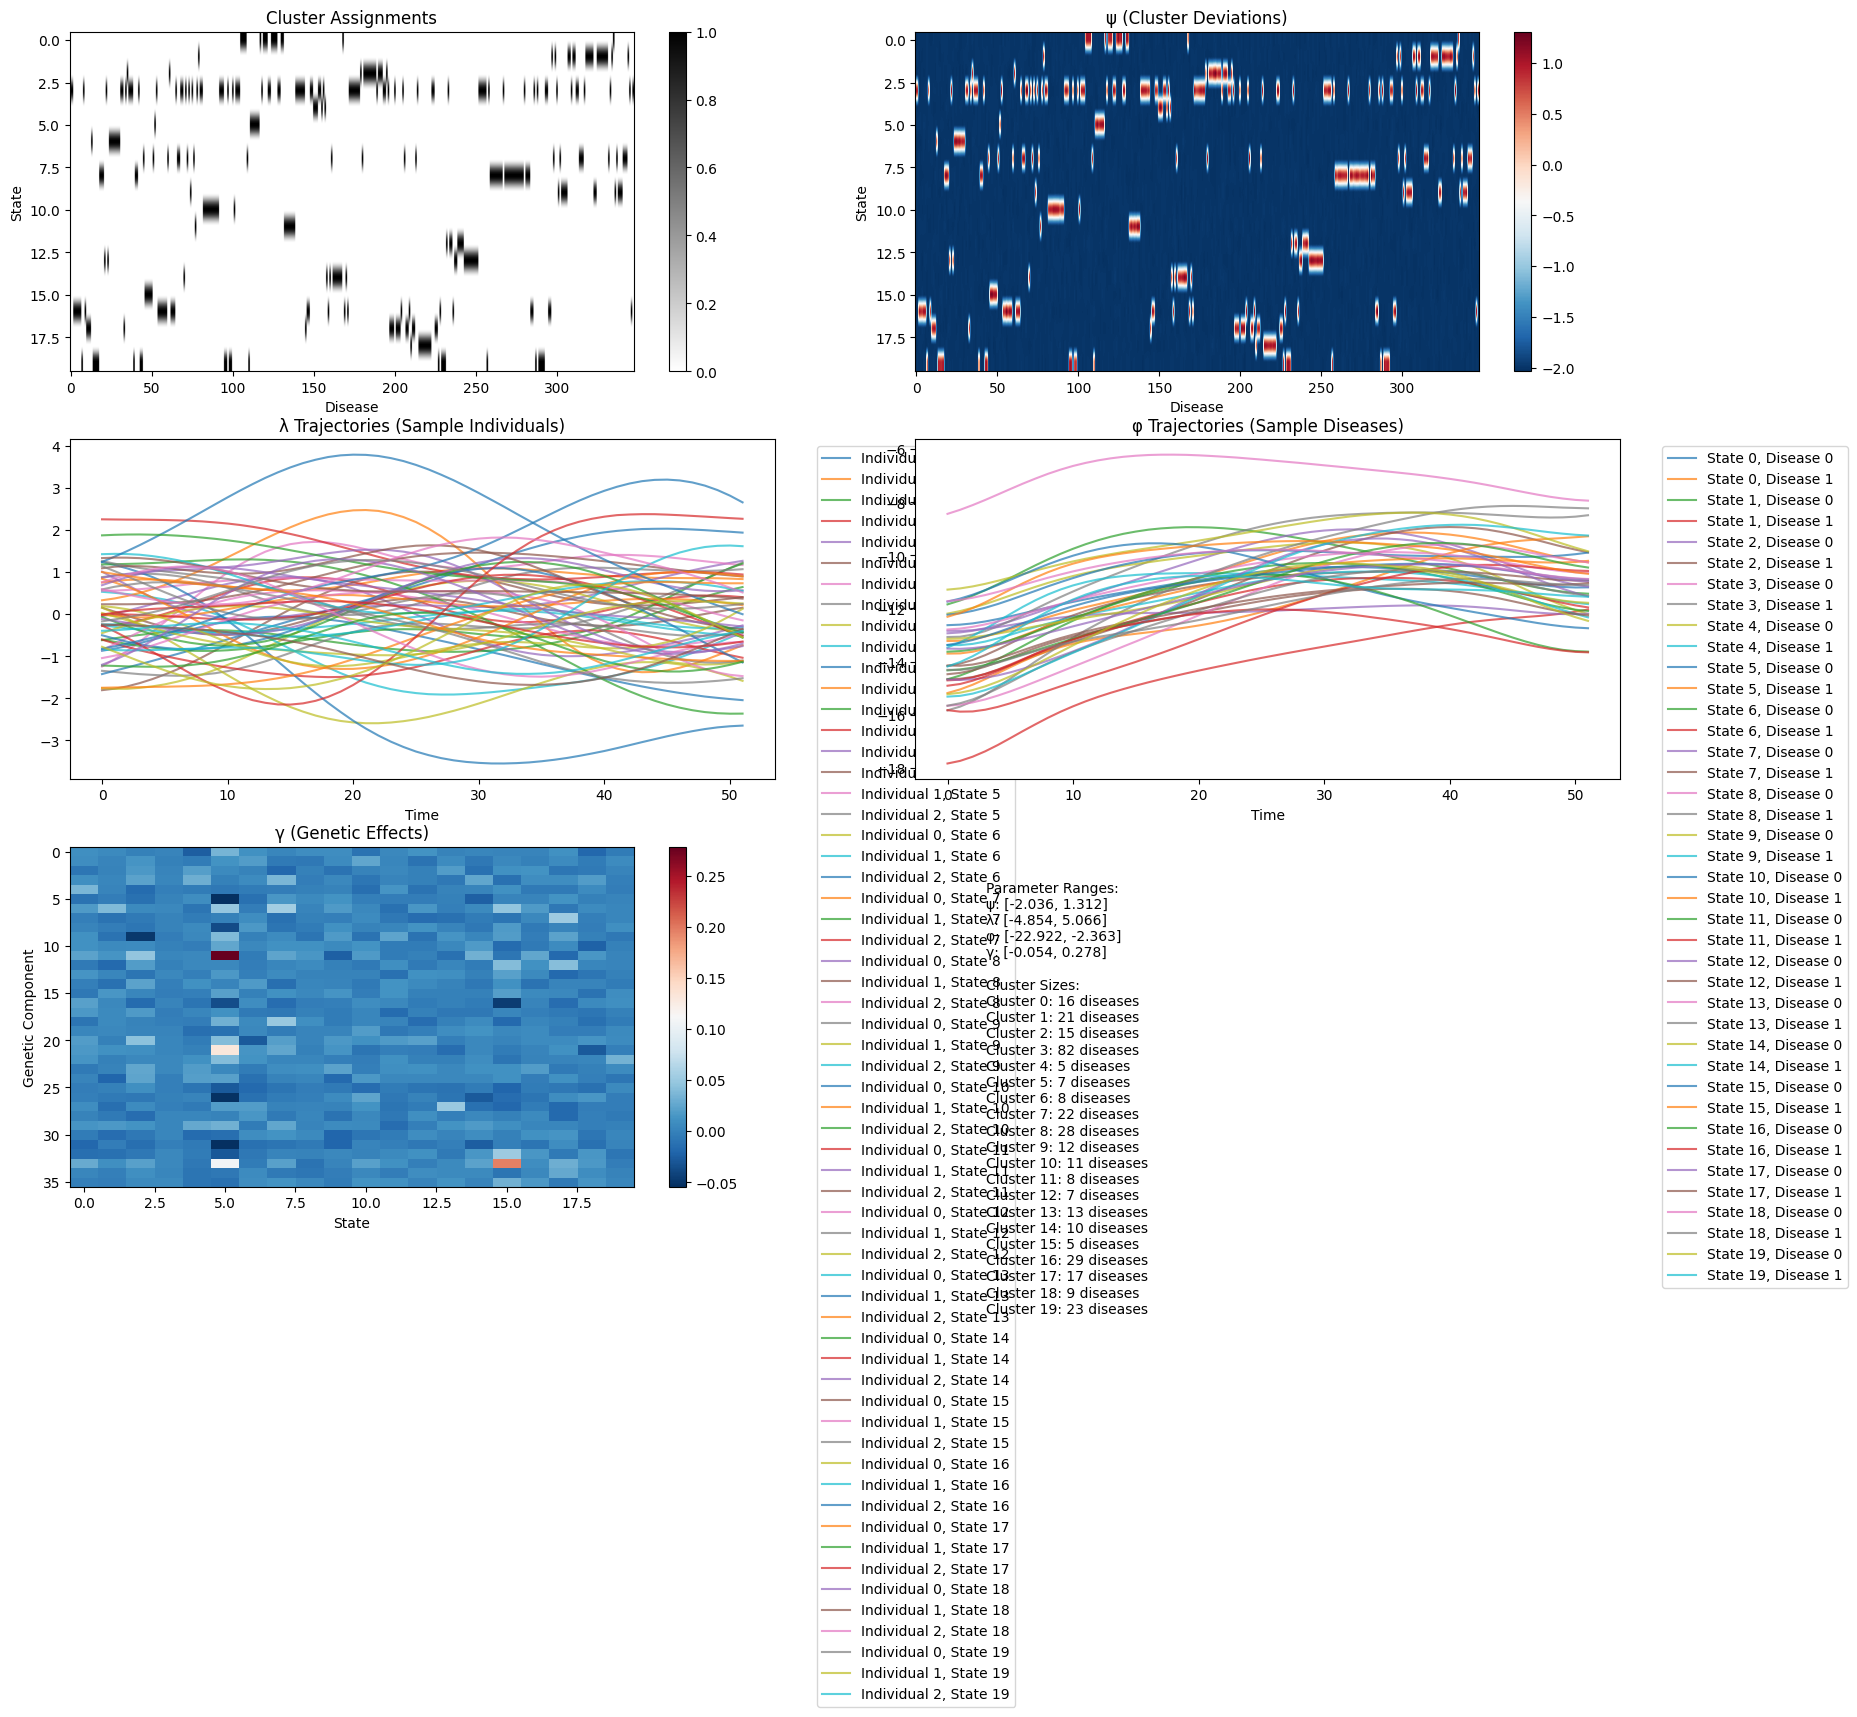

In [9]:
plot_results(model, history, disease_names, plot_dir)

In [ ]:
Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases